# Homework 1: Applied Machine Learning - Linear | Logisitc | SVM

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression as ll
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV,cross_val_score

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [3]:
pd.options.mode.chained_assignment = None

#**Part 1: Linear Regression**

In part 1, we will use **two datasets** to train and evaluate our linear regression model.

The first dataset will be a synthetic dataset sampled from the following equations:
   
**𝜖 ∼ Normal(0,3**)

**z = 3𝑥 + 10y + 10 + 𝜖**

In [4]:
np.random.seed(0)
epsilon = np.random.normal(0, 3, 100)
x = np.linspace(0, 10, 100) 
y = np.linspace(0, 5, 100)
z = 3 * x + 10 * y + 10 + epsilon

To apply linear regression, we need to first check if the assumptions of linear regression are not violated.

Assumptions of Linear Regression:

- Linearity: $y$ is a linear (technically affine) function of $x$.
- Independence: the $x$'s are independently drawn, and not dependent on each other.
- Homoscedasticity: the $\epsilon$'s, and thus the $y$'s, have constant variance.
- Normality: the $\epsilon$'s are drawn from a Normal distribution (i.e. Normally-distributed errors)

These properties, as well as the simplicity of this dataset, will make it a good test case to check if our linear regression model is working properly.

**1.1. Plot z vs x and z vs y in the synthetic dataset as scatter plots. Label your axes and make sure your y-axis starts from 0. Do the independent and dependent features have linear relationship?**

(-0.5, 10.5, 0.0, 98.7414498655559)

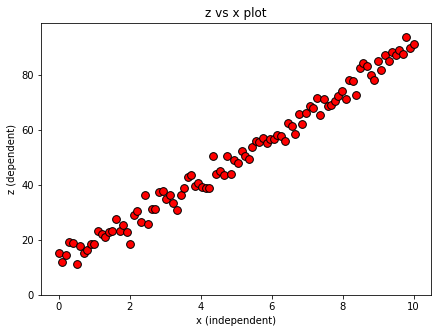

In [5]:
from IPython.core.pylabtools import figsize
### Your code here
fig, ax = plt.subplots(figsize = (7, 5))
ax.scatter(x,z, facecolor = 'r', edgecolor = 'k', s = 60)
ax.set_xlabel("x (independent)")
ax.set_ylabel("z (dependent)")
ax.set_title("z vs x plot")
ax.axis([-0.5, max(x) + 0.5, 0, max(z) + 5])

(-0.5, 5.5, 0.0, 98.7414498655559)

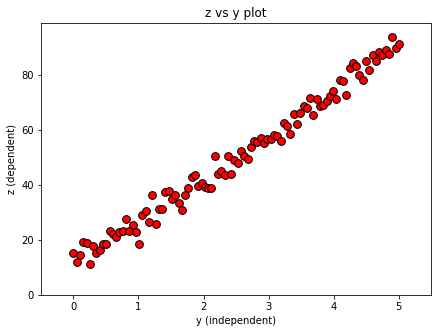

In [7]:
### Your code here
fig, ax = plt.subplots(figsize = (7, 5))
ax.scatter(y,z, facecolor = 'r', edgecolor = 'k', s = 60)
ax.set_xlabel("y (independent)")
ax.set_ylabel("z (dependent)")
ax.set_title("z vs y plot")
ax.axis([-0.5, max(y) + 0.5, 0, max(z) + 5])

Yes, they both have perfect linear relationship with z which is dependent variable.

**1.2. Are the independent variables correlated? Use pearson correlation to verify? What would be the problem if linear regression is applied to correlated features?**

the pearson coeffcient is 1.0


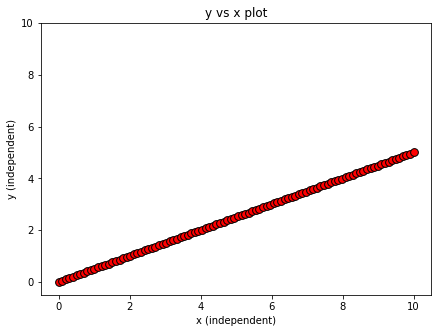

In [8]:
### Your code here
fig, ax = plt.subplots(figsize = (7, 5))
ax.scatter(x,y, facecolor = 'r', edgecolor = 'k', s = 60)
ax.set_xlabel("x (independent)")
ax.set_ylabel("y (independent)")
ax.set_title("y vs x plot")
ax.axis([-0.5, max(x) + 0.5, -0.5, max(y) + 5])

pearson_cor = np.corrcoef(x,y)
print("the pearson coeffcient is", pearson_cor[1][0])

Yes, the plot shows a perfect linear relationship between x and y. Also, the pearson coeffcient is 1 which indicate perfect correlation. Coeffcient of the linear model are unstable if there are collinearity between independent variables: a small change in data will result in a huge change in coefccient. (No unique solution to these coeffcients)

**The second dataset we will be using is an auto MPG dataset. This dataset contains various characteristics for around 8128 cars. We will use linear regression to predict the selling_price label**

In [9]:
auto_mpg_df = pd.read_csv('Car details v3.csv')
# Dropping Torque column, there is information in this column but it will take some preprocessing.
# The idea of the exercise is to familarize yourself with the basics of Linear regression.
auto_mpg_df = auto_mpg_df.drop(['torque'], axis = 1)

In [10]:
auto_mpg_df

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8123,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,5.0
8124,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,5.0
8125,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,73.9 bhp,5.0
8126,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,5.0


**1.3. Missing Value analysis - Auto mpg dataset.**

**Are there any missing values in the dataset? If so, what can be done about it? Jusify your approach.**

In [11]:
### Your code here
print (auto_mpg_df.isnull().sum())

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
seats            221
dtype: int64


Mileage, Engine and Max_power are numerical variables (after processing units and converting to numerical), it make senses to use mean to infer these missing data. In addition, these values are not differ too much from mean. However, Seat should be a discrete variable and decimal number of seats did not make sense. I will use the most frequent value in that column. I will impute these values after I remove units.

**1.4. The features engine, max_power and mileage have units in the dataset. In the real world if we have such datasets, we generally remove the units from each feature. After doing so, convert the datatype of these columns to float. For example: 1248 CC engine is 1248, 23.4 kmpl is 23.4 and so on.**

**Hint: Check for distinct units in each of these features. A feature might have multiple units as well. Also, a feature could have no value but have unit. For example 'CC' without any value. Remove such rows.**

In [12]:
### Your code here
def helper(s):
  if str(s) == 'nan':
    return s
  if str(s) == ' km/kg' or s == ' kmpl':
    return -1
  if str(s).endswith('km/kg'):
    return float(s.split(' ')[0]) * 1.41
  elif str(s).endswith('kmpl'):
    return float(s.split(' ')[0])
  else:
    return float(-1)

def helper2(s):
  if str(s) == 'nan':
    return s
  if str(s) == ' CC':
    return -1
  else :
    return float(str(s).split(' ')[0])

def helper3(s):
  if str(s) == 'nan':
    return s
  if str(s) == ' bhp':
    return -1
  else :
    return float(str(s).split(' ')[0])


## Remove all units, convert units and remove one row with only unit
auto_mpg_df['mileage']= auto_mpg_df.apply(lambda row : helper(row['mileage']), axis = 1)
auto_mpg_df['engine']= auto_mpg_df.apply(lambda row : helper2(row['engine']), axis = 1)
auto_mpg_df['max_power']= auto_mpg_df.apply(lambda row : helper3(row['max_power']), axis = 1)
auto_mpg_df = auto_mpg_df[auto_mpg_df['max_power'] != -1]
auto_mpg_df = auto_mpg_df[auto_mpg_df['engine'] != -1]
auto_mpg_df = auto_mpg_df[auto_mpg_df['mileage'] != -1]

## impute missing value
auto_mpg_df['max_power'] = auto_mpg_df['max_power'].fillna(auto_mpg_df['max_power'].mean(skipna=True))
auto_mpg_df['engine'] = auto_mpg_df['engine'].fillna(auto_mpg_df['engine'].mean(skipna=True))
auto_mpg_df['mileage'] = auto_mpg_df['mileage'].fillna(auto_mpg_df['mileage'].mean(skipna=True))
auto_mpg_df['seats'] = auto_mpg_df['seats'].fillna(auto_mpg_df['seats'].value_counts().index[0])

auto_mpg_X = auto_mpg_df.drop(columns=['selling_price'])
auto_mpg_y = auto_mpg_df['selling_price']
auto_mpg_X['year'] =  2020 - auto_mpg_X['year']
#dropping the car name as it is irrelevant.
auto_mpg_X.drop(['name'],axis = 1,inplace=True)
#check out the dataset with new changes
auto_mpg_X.head()

,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,6,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,5.0
1,6,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,14,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,5.0
3,10,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,5.0
4,13,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,5.0


**1.5. Plot the distribution of the label (selling_price) using a histogram. Make multiple plots with different binwidths. Make sure to label your axes while plotting.**

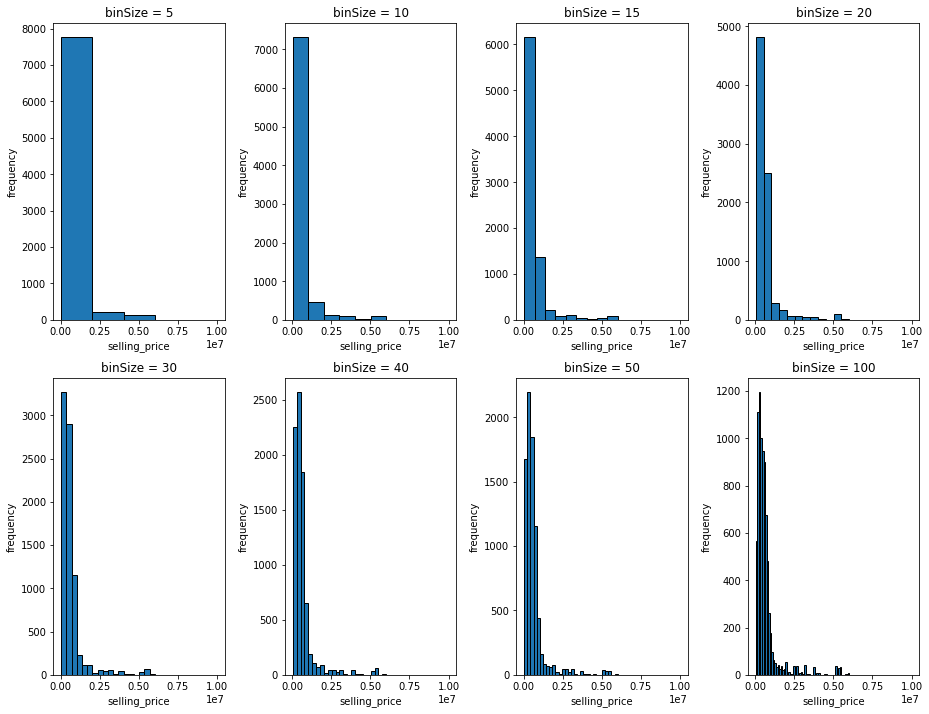

In [13]:
### Your code here
binNum = np.array([5,10,15,20,30,40,50,100])
fig, ax = plt.subplots(2,4,figsize = (13,10))
idx = 0
for i in range(2):
  for j in range(4):
    ax[i][j].hist(auto_mpg_y, bins = binNum[idx], edgecolor = 'k')
    ax[i][j].set_xlabel("selling_price")
    ax[i][j].set_ylabel("frequency")
    ax[i][j].set_title("binSize = " + str(binNum[idx]))
    idx = idx + 1

fig.tight_layout(pad = 1.0)

**1.6. Plot the relationships between the label (Selling Price) and the continuous features (Mileage, km driven, engine, max power) using a small multiple of scatter plots. 
Make sure to label the axes. Do you see something interesting about the distributions of these features.**

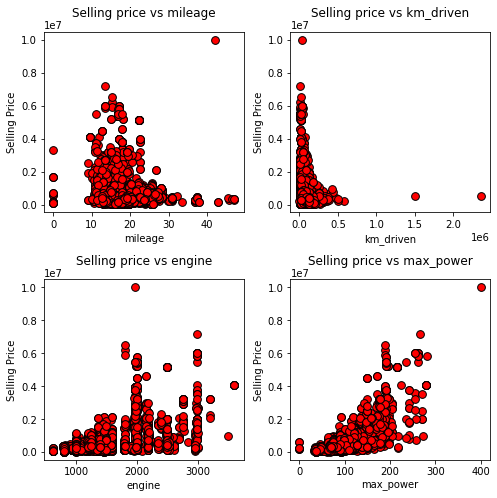

In [14]:
### Your code here
feature = np.array(['mileage','km_driven','engine','max_power'])
fig, ax = plt.subplots(2,2,figsize = (7,7))
idx = 0
for i in range(2):
  for j in range(2):
    ax[i][j].scatter(auto_mpg_X[feature[idx]],auto_mpg_y, facecolor = 'r', edgecolor = 'k', s = 60)
    ax[i][j].set_ylabel("Selling Price")
    ax[i][j].set_xlabel(feature[idx])
    ax[i][j].set_title("Selling price vs " + feature[idx], pad = 15)
    idx = idx + 1
fig.tight_layout(pad = 1.0)

Yes. There is a very very small postive linear relationship between selling price and max power. However, we cannot tell any linear relationship between selling price and other three features.

**1.7. Plot the relationships between the label (Selling Price) and the discrete features (fuel type, Seller type, transmission) using a small multiple of box plots. Make sure to label the axes.**

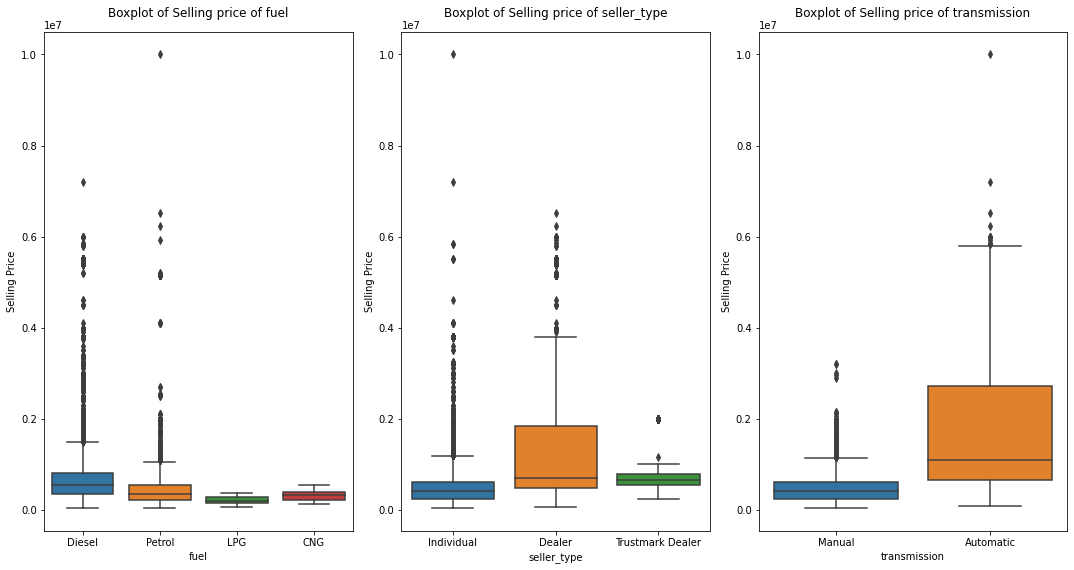

In [15]:
### Your code here
feature = np.array(['fuel','seller_type','transmission'])
fig, ax = plt.subplots(1,3,figsize = (15,8))
idx = 0
for j in range(3):
  sns.boxplot(ax=ax[j],x=auto_mpg_X[feature[idx]],y=auto_mpg_y)
  ax[j].set_ylabel("Selling Price")
  ax[j].set_xlabel(feature[idx])
  ax[j].set_title("Boxplot of Selling price of " + feature[idx], pad = 15)
  idx = idx + 1
fig.tight_layout(pad = 1.0)

**1.8. From the visualizations above, do you think linear regression is a good model for this problem? Why and/or why not?**

No. Because we cannot tell linear relationship between selling price and these continuous varaibles. Also, the selling price of each level of each categorical varaible shows no increasing or decreasing trends as level changes.

**Data Pre-processing**

**1.9.
Before we can fit a linear regression model, there are several pre-processing steps we should apply to the datasets:**
1. Encode categorial features appropriately.
2. Split the dataset into training (60%), validation (20%), and test (20%) sets.
3. Standardize the columns in the feature matrices X_train, X_val, and X_test to have zero mean and unit variance. To avoid information leakage, learn the standardization parameters (mean, variance) from X_train, and apply it to X_train, X_val, and X_test.
4. Add a column of ones to the feature matrices X_train, X_val, and X_test. This is a common trick so that we can learn a coefficient for the bias term of a linear model.


In [16]:
# 1. No categorical features in the synthetic dataset (skip this step)
auto_mpg_X = pd.concat((auto_mpg_X,pd.get_dummies(auto_mpg_X.seller_type)),1)
auto_mpg_X = auto_mpg_X.drop('seller_type',axis=1)
auto_mpg_X = pd.concat((auto_mpg_X,pd.get_dummies(auto_mpg_X.fuel)),1)
auto_mpg_X = auto_mpg_X.drop('fuel',axis=1)
auto_mpg_X = pd.concat((auto_mpg_X,pd.get_dummies(auto_mpg_X.transmission)),1)
auto_mpg_X = auto_mpg_X.drop('transmission',axis=1)
auto_mpg_X['owner'].unique()
scale_mapper = {"First Owner":1, "Second Owner":2, "Third Owner":3, "Fourth & Above Owner":4,
               "Test Drive Car":5}
auto_mpg_X['owner'] = auto_mpg_X['owner'].replace(scale_mapper)
feature_name = auto_mpg_X.columns
name=feature_name.tolist()
name.append('bias')

# 2. Split the dataset into training (60%), validation (20%), and test (20%) sets
auto_mpg_X_dev, auto_mpg_X_test, auto_mpg_y_dev, auto_mpg_y_test = train_test_split(auto_mpg_X,auto_mpg_y,test_size=0.2,random_state=44)
auto_mpg_X_train, auto_mpg_X_val, auto_mpg_y_train, auto_mpg_y_val  = train_test_split(auto_mpg_X_dev, auto_mpg_y_dev, test_size = 0.25, random_state = 44)

# 3. Standardize the columns in the feature matrices
ss = ColumnTransformer([
        ('somename', StandardScaler(), ['year', 'km_driven', 'owner', 'mileage', 'engine', 'max_power', 'seats'])
    ], remainder='passthrough')

#ss = StandardScaler()
auto_mpg_X_train = ss.fit_transform(auto_mpg_X_train)
auto_mpg_X_val = ss.transform(auto_mpg_X_val)
auto_mpg_X_test = ss.transform(auto_mpg_X_test)

# 4. Add a column of ones to the feature matrices
auto_mpg_X_train = np.append(auto_mpg_X_train,np.ones((auto_mpg_X_train.shape[0],1)), axis=1)
auto_mpg_X_val = np.append(auto_mpg_X_val,np.ones((auto_mpg_X_val.shape[0],1)), axis=1)
auto_mpg_X_test = np.append(auto_mpg_X_test,np.ones((auto_mpg_X_test.shape[0],1)), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  


**At the end of this pre-processing, you should have the following vectors and matrices:**

**- Auto MPG dataset: auto_mpg_X_train, auto_mpg_X_val, auto_mpg_X_test, auto_mpg_y_train, auto_mpg_y_val, auto_mpg_y_test**

**Implement Linear Regression**

Now, we can implement our linear regression model! Specifically, we will be implementing ridge regression, which is linear regression with L2 regularization. Given an (m x n) feature matrix $X$, an (m x 1) label vector $y$, and an (n x 1) weight vector $w$, the hypothesis function for linear regression is:

$$
y = X w
$$

Note that we can omit the bias term here because we have included a column of ones in our $X$ matrix, so the bias term is learned implicitly as a part of $w$. This will make our implementation easier.

Our objective in linear regression is to learn the weights $w$ which best fit the data. This notion can be formalized as finding the optimal $w$ which minimizes the following loss function:

$$
\min_{w} \| X w - y \|^2_2 + \alpha \| w \|^2_2 \\
$$

This is the ridge regression loss function. The $\| X w - y \|^2_2$ term penalizes predictions $Xw$ which are not close to the label $y$. And the $\alpha \| w \|^2_2$ penalizes large weight values, to favor a simpler, more generalizable model. The $\alpha$ hyperparameter, known as the regularization parameter, is used to tune the complexity of the model - a higher $\alpha$ results in smaller weights and lower complexity, and vice versa. Setting $\alpha = 0$ gives us vanilla linear regression.

Conveniently, ridge regression has a closed-form solution which gives us the optimal $w$ without having to do iterative methods such as gradient descent. The closed-form solution, known as the Normal Equations, is given by:

$$
w = (X^T X + \alpha I)^{-1} X^T y
$$

**1.10. Implement a `LinearRegression` class with two methods: `train` and `predict`. You may NOT use sklearn for this implementation. You may, however, use `np.linalg.solve` to find the closed-form solution. It is highly recommended that you vectorize your code.**

In [17]:
class LinearRegression():
    '''
    Linear regression model with L2-regularization (i.e. ridge regression).

    Attributes
    ----------
    alpha: regularization parameter
    w: (n x 1) weight vector
    '''
    
    def __init__(self, alpha=0):
        self.alpha = alpha
        self.w = None

    def train(self, X, y):
        '''Trains model using ridge regression closed-form solution 
        (sets w to its optimal value).
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        None
        '''
        ### Your code here
        n = X.shape[1]
        I = np.eye(n, dtype=int)
        I[n-1,n-1] = 0
        self.w = np.linalg.pinv(X.T.dot(X) + self.alpha * I).dot(X.T).dot(y)

    def predict(self, X):
        '''Predicts on X using trained model.
        
        Parameters
        ----------
        X : (m x n) feature matrix
        
        Returns
        -------
        y_pred: (m x 1) prediction vector
        '''
        ### Your code here
        return X.dot(self.w)

**Train, Evaluate, and Interpret Linear Regression Model**

**1.11. A) Train a linear regression model ($\alpha = 0$) on the auto MPG training data. Make predictions and report the mean-squared error (MSE) on the training, validation, and test sets. Report the first 5 predictions on the test set, along with the actual labels.**

In [18]:
### Your code here
lg = LinearRegression()
lg.train(auto_mpg_X_train,auto_mpg_y_train)
y_train = lg.predict(auto_mpg_X_train)
y_val = lg.predict(auto_mpg_X_val)
y_test = lg.predict(auto_mpg_X_test)
MSE_train = np.sum(np.square(auto_mpg_y_train - y_train))/auto_mpg_y_train.shape[0]
MSE_val = np.sum(np.square(auto_mpg_y_val - y_val))/auto_mpg_y_val.shape[0]
MSE_test = np.sum(np.square(auto_mpg_y_test - y_test))/auto_mpg_y_test.shape[0]
print("MSE_train:",MSE_train,"MSE_val:", MSE_val, "MSE_test:",MSE_test)
First_Five = pd.DataFrame({'Actual Price':auto_mpg_y_test[0:5], 'Predicted Price':y_test[0:5]})
print("First Five Pair:\n", First_Five)

MSE_train: 204590925418.1649 MSE_val: 216621401953.75537 MSE_test: 222295370667.45895
First Five Pair:
       Actual Price  Predicted Price
4797        810000     1.014274e+06
7087        260000     5.280174e+04
2025        350000     1.053963e+06
3606        620000     9.105497e+05
3288        300000     1.517141e+05


**B) As a baseline model, use the mean of the training labels (auto_mpg_y_train) as the prediction for all instances. Report the mean-squared error (MSE) on the training, validation, and test sets using this baseline. This is a common baseline used in regression problems and tells you if your model is any good. Your linear regression MSEs should be much lower than these baseline MSEs.**

In [19]:
### Your code here
y_mean = auto_mpg_y_train.mean()
MSE_train_base = np.sum(np.square(auto_mpg_y_train - y_mean))/auto_mpg_y_train.shape[0]
MSE_val_base = np.sum(np.square(auto_mpg_y_val - y_mean))/auto_mpg_y_val.shape[0]
MSE_test_base = np.sum(np.square(auto_mpg_y_test - y_mean))/auto_mpg_y_test.shape[0]
print("MSE_train_base:",MSE_train_base,"MSE_val_base:", MSE_val_base,"MSE_test_base:", MSE_test_base)


MSE_train_base: 650893996741.5502 MSE_val_base: 593167633223.5981 MSE_test_base: 704203637142.1959


**1.12. Interpret your model trained on the auto MPG dataset using a bar chart of the model weights. Make sure to label the bars (x-axis) and don't forget the bias term! Use lecture 3, slide 15 as a reference. According to your model, which features are the greatest contributors to the selling price**

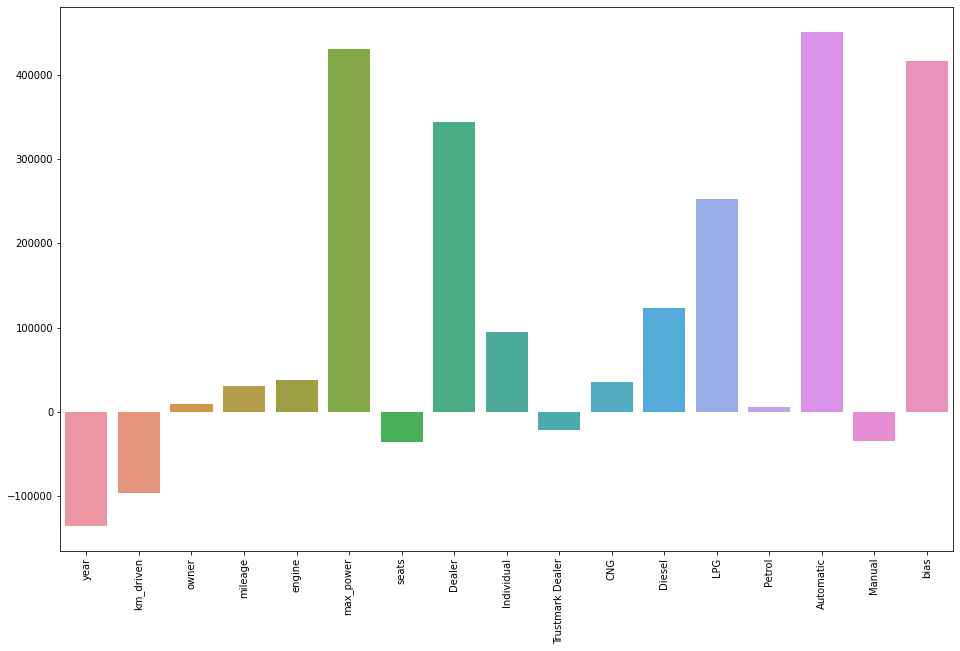

In [20]:
### Your code here
fig = plt.figure(figsize=(16,10))
ax = sns.barplot(x=name, y=lg.w)
ax.tick_params(axis='x',rotation=90)

It turns out that max_power has positive affect on the price and km_driven and year has negative affect on the price. Also, the transmission type of manual affect the price negatively.

**Tune Regularization Parameter $\alpha$**

**Now, let's do ridge regression and tune the $\alpha$ regularization parameter on the auto MPG dataset.**

**1.13. Sweep out values for $\alpha$ using `alphas = np.logspace(-2, 1, 10)`. Perform a grid search over these $\alpha$ values, recording the training and validation MSEs for each $\alpha$. A simple grid search is fine, no need for k-fold cross validation. Plot the training and validation MSEs as a function of $\alpha$ on a single figure. Make sure to label the axes and the training and validation MSE curves. Use a log scale for the x-axis.**

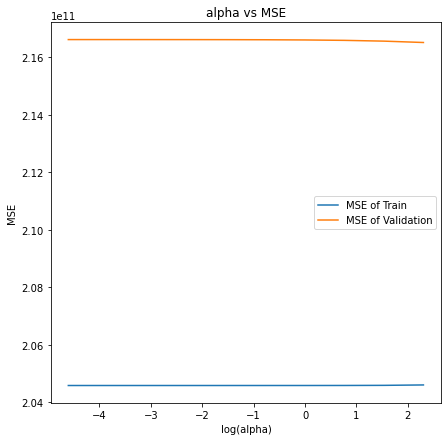

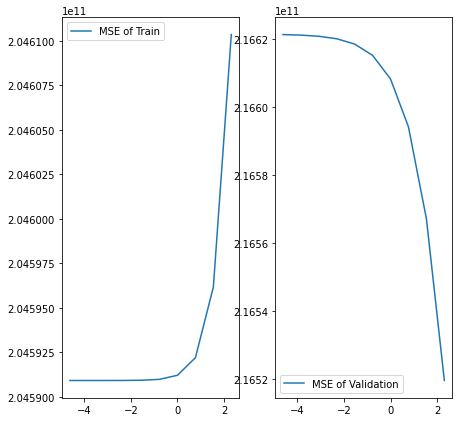

In [23]:
### Your code here
alphas = np.logspace(-2,1,10)
MSE_train_alpha = []
MSE_val_alpha = []
for i in alphas:
  lg = LinearRegression(i)
  lg.train(auto_mpg_X_train, auto_mpg_y_train)
  y_train = lg.predict(auto_mpg_X_train)
  y_val = lg.predict(auto_mpg_X_val)
  MSE_train = np.sum(np.square(auto_mpg_y_train - y_train))/auto_mpg_y_train.shape[0]
  MSE_val = np.sum(np.square(auto_mpg_y_val - y_val))/auto_mpg_y_val.shape[0]
  MSE_train_alpha.append(MSE_train)
  MSE_val_alpha.append(MSE_val)

### Your answer here
fig,ax = plt.subplots(figsize = (7,7))
sns.lineplot(ax=ax,x= np.log(alphas), y=MSE_train_alpha, label = 'MSE of Train')
sns.lineplot(ax=ax, x=np.log(alphas), y=MSE_val_alpha,label= 'MSE of Validation')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('MSE')
ax.set_title('alpha vs MSE')
ax.legend()


fig,ax = plt.subplots(1,2, figsize = (7,7))
sns.lineplot(ax=ax[0],x= np.log(alphas), y=MSE_train_alpha, label = 'MSE of Train')
sns.lineplot(ax=ax[1], x=np.log(alphas), y=MSE_val_alpha,label= 'MSE of Validation')

**Explain your plot above. How do training and validation MSE behave with decreasing model complexity (increasing $\alpha$)?**

As alpha increasing, the training error increases because we increase the bias and reduces the variance. On the other hand, the validation error keeps decresing which shows that our complex model is overfitting to the train data. As we reducing the complexity, the overfitting is resolved. One thing to notice that when doing one-hot encoding, it introduces collinearity which is resolved by tuning of alpha.

**1.14. Using the $\alpha$ which gave the best validation MSE above, train a model on the training set. Report the value of $\alpha$ and its training, validation, and test MSE. This is the final tuned model which you would deploy in production.**

In [26]:
### Your code here
idx = MSE_val_alpha.index(min(MSE_val_alpha))
alpha = alphas[idx]
lr = LinearRegression(alpha)
lr.train(auto_mpg_X_train,auto_mpg_y_train)
y_pred = lr.predict(auto_mpg_X_test)
y_pred_train = lr.predict(auto_mpg_X_train)
y_pred_val = lr.predict(auto_mpg_X_val)
MSE = np.sum(np.square(auto_mpg_y_test - y_pred))/auto_mpg_y_test.shape[0]
MSE_train = np.sum(np.square(auto_mpg_y_train - y_pred_train))/auto_mpg_y_train.shape[0]
MSE_val = np.sum(np.square(auto_mpg_y_val - y_pred_val))/auto_mpg_y_val.shape[0]
print("alpha is:", alpha, "MSE of testing data is:", MSE, "MSE of training data is:", MSE_train, "MSE of val data is:", MSE_val)

alpha is: 10.0 MSE of testing data is: 222274960966.51715 MSE of training data is: 204610339701.2344 MSE of val data is: 216519475519.2476


# **Part 2: Logistic Regression**

**Gender Recognition by Voice and Speech Analysis**

**This dataset is used to identify a voice as male or female, based upon acoustic properties of the voice and speech.**

In [27]:
voice_df = pd.read_csv("voice-classification.csv")
voice_df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


**Data - Checking Rows & Columns**

In [28]:
#Number of Rows & Columns
print(voice_df.shape) 

(3168, 21)


**2.1 What is the probability of observing different  categories in the Label feature of the dataset?**

This is mainly to check class imbalance in the dataset, and to apply different techniques to balance the dataset, which we will learn later.

In [29]:
#code here
n = voice_df.shape[0]
n_male = voice_df[voice_df['label']=='male'].shape[0]
prob_male = n_male / n
prob_female = (n - n_male) / n
print('probability of observing male:', prob_male, 'probability of observing female:', prob_female)

probability of observing male: 0.5 probability of observing female: 0.5


**2.2 Plot the relationships between the label and the 20 numerical features using a small multiple of box plots. Make sure to label the axes. What useful information do this plot provide?**

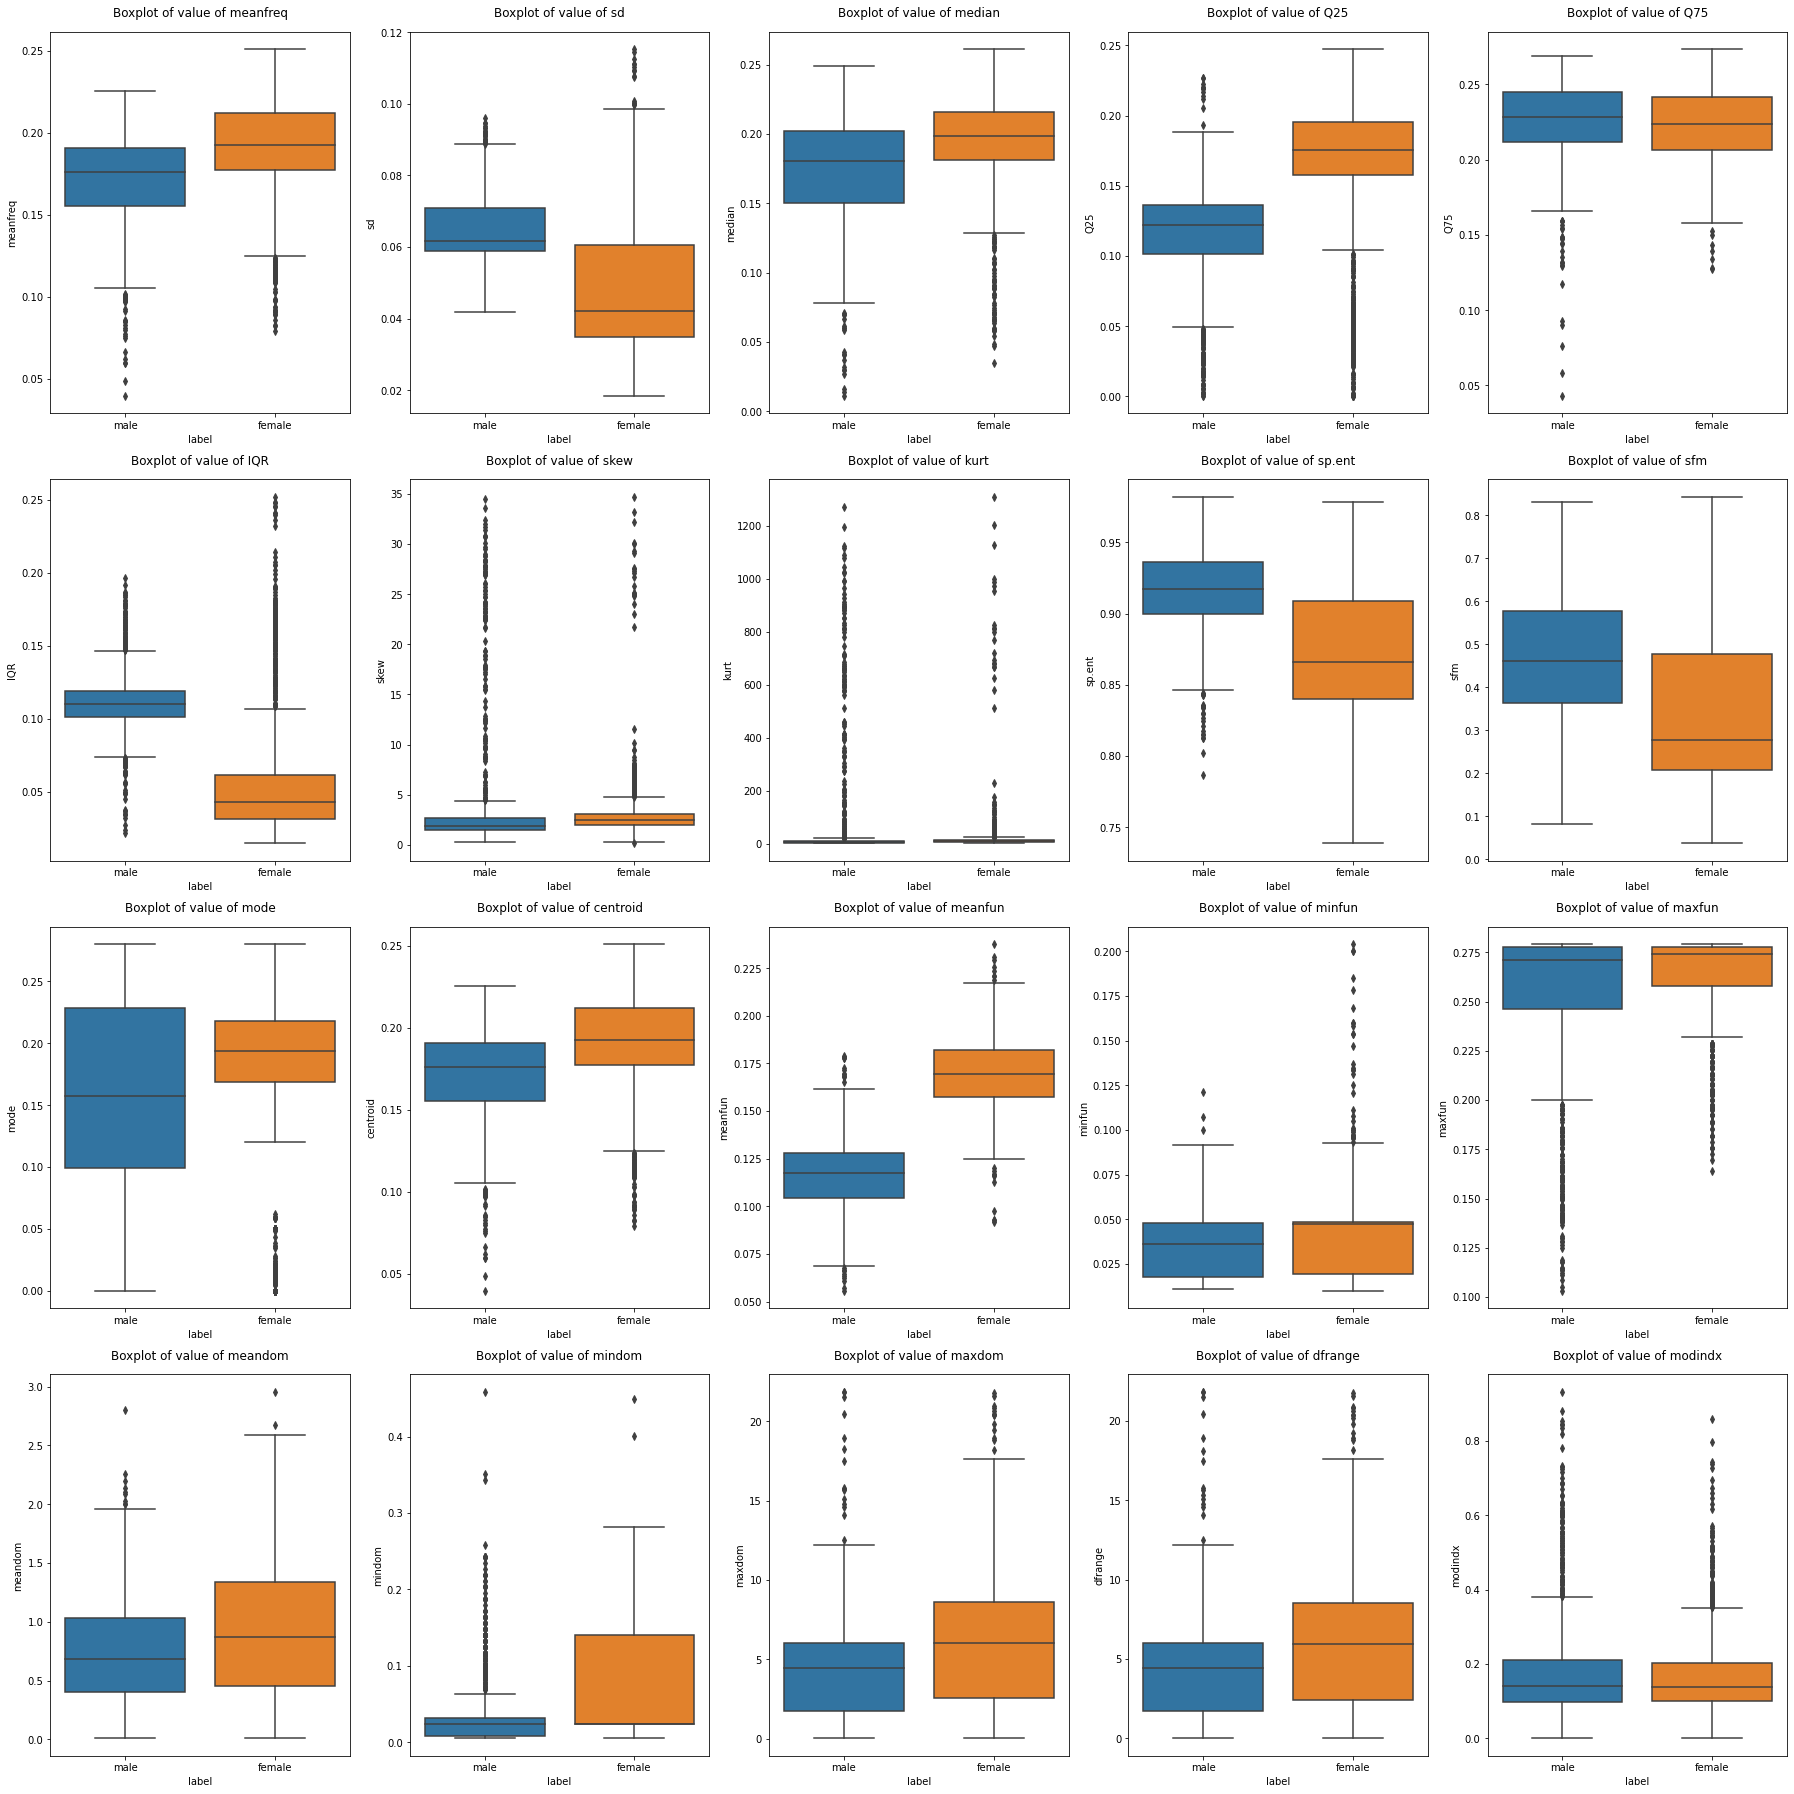

In [30]:
#code here
feature = voice_df.columns.tolist()
feature.pop()
fig, ax = plt.subplots(4,5,figsize = (25,25))
idx = 0
for i in range(4):
  for j in range(5):
    sns.boxplot(ax=ax[i][j],x=voice_df['label'],y=voice_df[feature[idx]])
    ax[i][j].set_ylabel(feature[idx])
    ax[i][j].set_xlabel('label')
    ax[i][j].set_title("Boxplot of value of " + feature[idx], pad = 15)
    idx = idx + 1
fig.tight_layout(pad = 1.0)

We can tell that in general, female have higher meanfun, meanfreq, Q25, centroid and mindom. However, male in general have higher sd, sq.ent, IQR. However, we can only talk about the shape of each feature's distribution between male and female.

**2.3 Plot the correlation matrix, and check if there is high correlation between the given numerical features (Threshold >=0.9). If yes, drop those highly correlated features from the dataframe. Why is necessary to drop those columns before proceeding further?**

Dropping these features make our coeffcient more stable (robust to small change in data). In addition, we may misunderstand some relationships between features and label.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


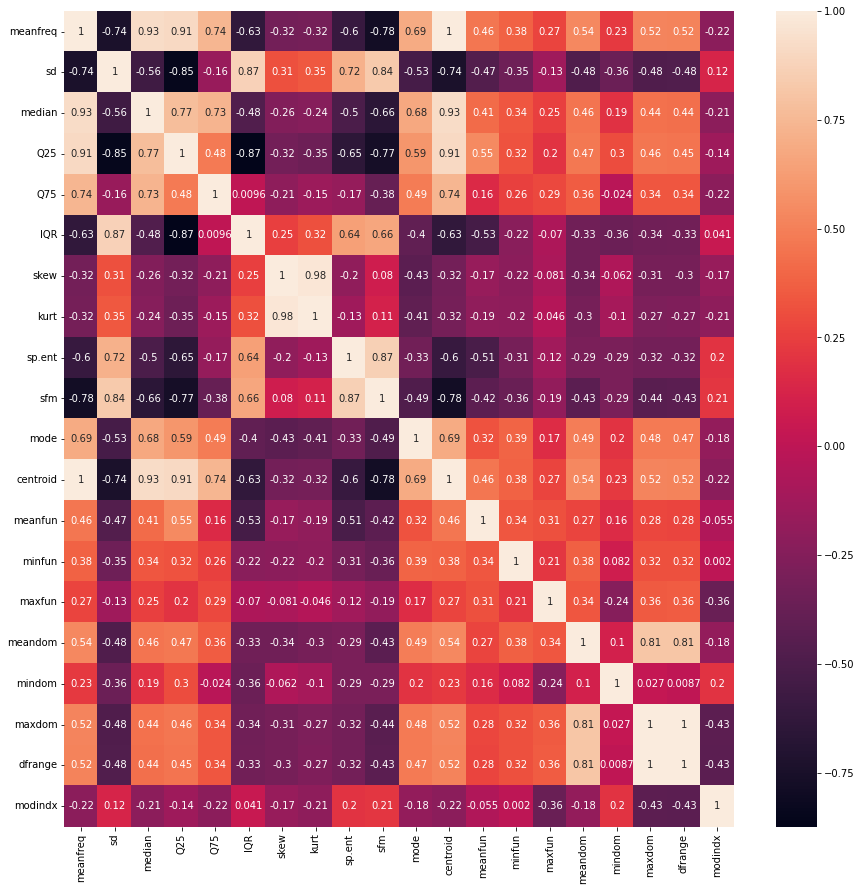

In [31]:
#code here
corr = voice_df.corr()
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(ax=ax, data = corr, annot= True)
corr_m = corr.abs()
cand = corr_m.where(np.triu(np.ones(corr_m.shape),k=1).astype(np.bool))
drop = [column for column in cand.columns if any(cand[column] >= 0.9)]
voice_df = voice_df.drop(columns=drop)

**Separating Features & Y variable from the processed dataset**

**Please note to replace the dataframe below with the new dataframe created after removing highly correlated features**

In [32]:
# Split data into features and labels
voice_X = voice_df.drop(columns=['label']) #replace "voice_df1" with your dataframe from 2.3 to make sure the code runs
voice_y = voice_df['label']
name = voice_X.columns.tolist()
name.append('bias')

**2.4 Apply the following pre-processing steps:**

1) Use OrdinalEncoding to encode the label in the dataset (male & female)

2) Convert the label from a Pandas series to a Numpy (m x 1) vector. If you don't do this, it may cause problems when implementing the logistic regression model.

3)Split the dataset into training (60%), validation (20%), and test (20%) sets.

4) Standardize the columns in the feature matrices. To avoid information leakage, learn the standardization parameters from training, and then apply training, validation and test dataset.

5) Add a column of ones to the feature matrices of train, validation and test dataset. This is a common trick so that we can learn a coefficient for the bias term of a linear model.

In [33]:
#code here
scale_mapper = {"male":0, "female":1}
voice_y = voice_y.replace(scale_mapper)
voice_y=np.vstack(voice_y.to_numpy())

voice_X_dev, voice_X_test, voice_y_dev, voice_y_test = train_test_split(voice_X,voice_y,test_size=0.2,random_state=44)
voice_X_train, voice_X_val, voice_y_train, voice_y_val  = train_test_split(voice_X_dev, voice_y_dev, test_size = 0.25, random_state = 44)

ss = MinMaxScaler()
voice_X_train = ss.fit_transform(voice_X_train)
voice_X_val = ss.transform(voice_X_val)
voice_X_test = ss.transform(voice_X_test)

voice_X_train = np.append(voice_X_train,np.ones((voice_X_train.shape[0],1)), axis=1)
voice_X_val = np.append(voice_X_val,np.ones((voice_X_val.shape[0],1)), axis=1)
voice_X_test = np.append(voice_X_test,np.ones((voice_X_test.shape[0],1)), axis=1)

**2.5 Implement Logistic Regression**

We will now implement logistic regression with L2 regularization. Given an (m x n) feature matrix $X$, an (m x 1) label vector $y$, and an (n x 1) weight vector $w$, the hypothesis function for logistic regression is:

$$
y = \sigma(X w)
$$

where $\sigma(x) = \frac{1}{1 + e^{-x}}$, i.e. the sigmoid function. This function scales the prediction to be a probability between 0 and 1, and can then be thresholded to get a discrete class prediction.

Just as with linear regression, our objective in logistic regression is to learn the weights $𝑤$ which best fit the data. For L2-regularized logistic regression, we find an optimal $w$ to minimize the following loss function:

$$
\min_{w} \ -y^T \ \text{log}(\sigma(Xw)) \ - \  (\mathbf{1} - y)^T \ \text{log}(\mathbf{1} - \sigma(Xw)) \ + \ \alpha \| w \|^2_2 \\
$$

Unlike linear regression, however, logistic regression has no closed-form solution for the optimal $w$. So, we will use gradient descent to find the optimal $w$. The (n x 1) gradient vector $g$ for the loss function above is:

$$
g = X^T \Big(\sigma(Xw) - y\Big) + 2 \alpha w
$$

Below is pseudocode for gradient descent to find the optimal $w$. You should first initialize $w$ (e.g. to a (n x 1) zero vector). Then, for some number of epochs $t$, you should update $w$ with $w - \eta g $, where $\eta$ is the learning rate and $g$ is the gradient. You can learn more about gradient descent [here](https://www.coursera.org/lecture/machine-learning/gradient-descent-8SpIM).

> $w = \mathbf{0}$
> 
> $\text{for } i = 1, 2, ..., t$
>
> $\quad \quad w = w - \eta g $


Implement a LogisticRegression class with five methods: train, predict, calculate_loss, calculate_gradient, and calculate_sigmoid. **You may NOT use sklearn for this implementation. It is highly recommended that you vectorize your code.**

In [34]:
class LogisticRegression():
    '''
    Logistic regression model with L2 regularization.

    Attributes
    ----------
    alpha: regularization parameter
    t: number of epochs to run gradient descent
    eta: learning rate for gradient descent
    w: (n x 1) weight vector
    '''
    
    def __init__(self, alpha, t, eta):
        self.alpha = alpha
        self.t = t
        self.eta = eta
        self.w = None

    def train(self, X, y):
        '''Trains logistic regression model using gradient descent 
        (sets w to its optimal value).
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        losses: (t x 1) vector of losses at each epoch of gradient descent
        '''
        ### Your code here
        n = X.shape[1]
        
        self.w = np.zeros((n,1))
        losses = np.zeros((self.t,1))
        for i in range(self.t):
          self.w = self.w - self.eta * self.calculate_gradient(X, y)
          losses[i] = self.calculate_loss(X,y)
        return losses

    def predict(self, X):
        '''Predicts on X using trained model. Make sure to threshold 
        the predicted probability to return a 0 or 1 prediction.
        
        Parameters
        ----------
        X : (m x n) feature matrix
        
        Returns
        -------
        y_pred: (m x 1) 0/1 prediction vector
        '''
        ### Your code here
        y = self.calculate_sigmoid(X.dot(self.w))
        
        y[y>0.5] = 1
        y[y <= 0.5] = 0
        
        return y

    def calculate_loss(self, X, y):
        '''Calculates the logistic regression loss using X, y, w, 
        and alpha. Useful as a helper function for train().
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        loss: (scalar) logistic regression loss
        '''
        ### Your code here
        sigmoid = self.calculate_sigmoid(X.dot(self.w))
        
        loss = -y.T.dot(np.log(sigmoid)) - (1-y).T.dot(np.log(1-sigmoid)) + self.alpha*np.square(np.linalg.norm(self.w))
        
        return loss

    def calculate_gradient(self, X, y):
        '''Calculates the gradient of the logistic regression loss 
        using X, y, w, and alpha. Useful as a helper function 
        for train().
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        gradient: (n x 1) gradient vector for logistic regression loss
        '''
        ### Your code here
        gradient = X.T.dot(self.calculate_sigmoid(X.dot(self.w)) - y) + 2*self.alpha*self.w
        
        return gradient

    def calculate_sigmoid(self, x):
        '''Calculates the sigmoid function on each element in vector x. 
        Useful as a helper function for predict(), calculate_loss(), 
        and calculate_gradient().
        
        Parameters
        ----------
        x: (m x 1) vector
        
        Returns
        -------
        sigmoid_x: (m x 1) vector of sigmoid on each element in x
        '''
        ### Your code here
        return 1/(1 + np.exp(-x))

**2.6 Plot Loss over Epoch and Search the space randomly to find best hyperparameters.**

A: Using your implementation above, train a logistic regression model **(alpha=0, t=100, eta=1e-3)** on the voice recognition training data. Plot the training loss over epochs. Make sure to label your axes. You should see the loss decreasing and start to converge. 

B: Using **alpha between (0,1), eta between(0, 0.001) and t between (0, 100)**, find the best hyperparameters for LogisticRegression. You can randomly search the space 20 times to find the best hyperparameters.

C. Compare accuracy on the test dataset for both the scenarios.

accuracy for no penalty: 0.9416403785488959
accuracy with alpha: [0.42385505] with t: 97 with eta: [0.00080619] is 0.9321766561514195


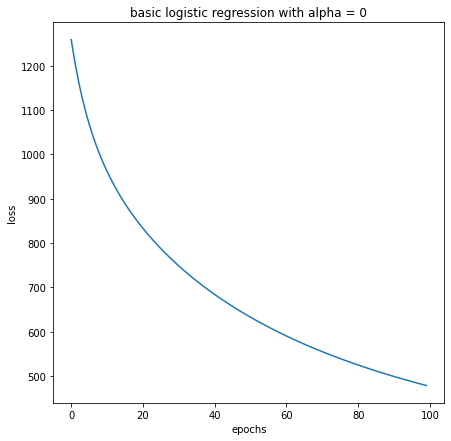

In [35]:
from numpy.core.numeric import NaN
from contextlib import nullcontext
#code here
#A
lrA = LogisticRegression(0,100,1e-3)
loss = lrA.train(voice_X_train, voice_y_train)
fig, ax = plt.subplots(figsize = (7,7))
sns.lineplot(ax = ax, x = range(100), y = loss[:,0])
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title('basic logistic regression with alpha = 0')
#B
alpha = np.random.rand(20,1)
eta = np.random.rand(20,1) / 1000
t = np.floor(np.random.rand(20,1)*100)
ac = np.zeros((20,1))
lrB = NaN
ac = 0
t_best = 0
alpha_best = 0
eta_best = 0
for i in range(20):
  lrTemp = LogisticRegression(alpha[i],int(t[i]),eta[i])
  loss = lrTemp.train(voice_X_train, voice_y_train)
  y_predict_val = lrTemp.predict(voice_X_val)
  ac_temp = np.sum(y_predict_val==voice_y_val)/voice_y_val.shape[0]
  if ac < ac_temp:
    ac = ac_temp
    t_best = t[i]
    alpha_best = alpha[i]
    eta_best = eta[i]
    lrB = lrTemp

#C
y_predict_A = lrA.predict(voice_X_test)
accuracy_A = np.sum(y_predict_A==voice_y_test)/voice_y_test.shape[0]
y_predict_B = lrB.predict(voice_X_test)
accuracy_B = np.sum(y_predict_B==voice_y_test)/voice_y_test.shape[0]
print('accuracy for no penalty:', accuracy_A)
print('accuracy with alpha:', alpha_best, 'with t:', int(t_best), 'with eta:', eta_best, 'is', accuracy_B)

It makes sense that random search did not beat the original model because we eliminate all these collinearity which makes penalty useless.

**2.7 Feature Importance**

Interpret your trained model using a bar chart of the model weights. Make sure to label the bars (x-axis) and don't forget the bias term! 

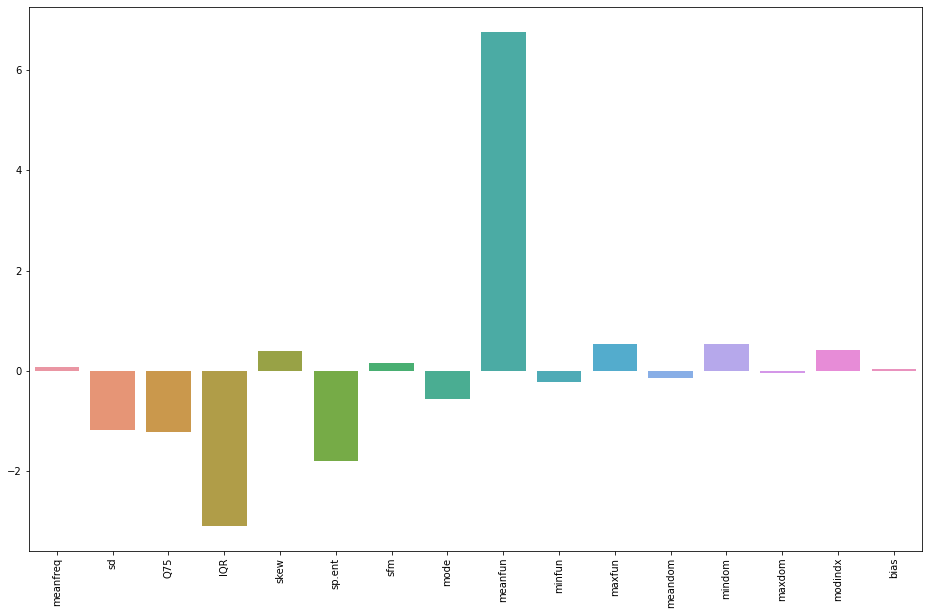

In [36]:
#code here

fig = plt.figure(figsize=(16,10))
ax = sns.barplot(x=name, y=lrA.w[:,0])
ax.tick_params(axis='x',rotation=90)

we can tell that meanfun contribute to the positive relationship between female (high meanfun, larger prob for female) and IQR and sp.ent contributes to the prediction of male.


# **Part 3: Support Vector Machines - with the same Dataset**

**3.1 Dual SVM**

A) Train a dual SVM (with default parameters) for both kernel=“linear” and kernel=“rbf”) on the Voice Recognition training data.

B) Make predictions and report the accuracy on the training, validation, and test sets. Which kernel gave better accuracy on test dataset and why do you think that was better?

C) Please report the support vectors in both the cases and what do you observe? Explain


In [39]:
#code here
#A
sc_linear = SVC(kernel = 'linear')
sc_rbf = SVC(kernel = 'rbf')
sc_linear.fit(voice_X_train, np.ravel(voice_y_train))
sc_rbf.fit(voice_X_train, np.ravel(voice_y_train))
#B
y_linear_train = sc_linear.predict(voice_X_train)
y_linear_val = sc_linear.predict(voice_X_val)
y_linear_test = sc_linear.predict(voice_X_test)


y_rbf_train = sc_rbf.predict(voice_X_train)
y_rbf_val = sc_rbf.predict(voice_X_val)
y_rbf_test = sc_rbf.predict(voice_X_test)

accuracy_linear_test = np.mean(np.vstack(y_linear_test)==voice_y_test)
accuracy_rbf_test = np.mean(np.vstack(y_rbf_test)==voice_y_test)
print("accuracy on test data by linear kernel:", accuracy_linear_test, "accuracy on test data by rbf kernel:", accuracy_rbf_test)

#C
print('the svm of linear:', sc_linear.support_vectors_)
print('-----------------------------------------')
print('the svm of rbf:', sc_rbf.support_vectors_)

accuracy on test data by linear kernel: 0.9684542586750788 accuracy on test data by rbf kernel: 0.973186119873817
the svm of linear: [[1.80489720e-01 7.04716003e-01 3.92065247e-01 ... 3.57398142e-04
  5.28839837e-02 1.00000000e+00]
 [8.64296655e-01 3.14765336e-01 9.14935637e-01 ... 9.25661187e-02
  9.60553984e-02 1.00000000e+00]
 [7.52329174e-01 4.58323281e-01 9.26861259e-01 ... 2.62330236e-01
  1.13778229e-01 1.00000000e+00]
 ...
 [6.58181749e-01 4.59223167e-01 7.77200029e-01 ... 2.71622588e-02
  1.02793804e-01 1.00000000e+00]
 [6.79825082e-01 2.27970887e-01 6.93336051e-01 ... 4.01715511e-01
  1.11001530e-01 1.00000000e+00]
 [5.11977748e-01 6.66095715e-01 7.26124165e-01 ... 3.57398142e-02
  2.56700891e-01 1.00000000e+00]]
-----------------------------------------
the svm of rbf: [[1.80489720e-01 7.04716003e-01 3.92065247e-01 ... 3.57398142e-04
  5.28839837e-02 1.00000000e+00]
 [7.94345058e-01 3.74971354e-01 9.14366269e-01 ... 1.96568978e-02
  4.01971694e-01 1.00000000e+00]
 [8.6429665

The rbf svm gives us a better prediction on the test dataset. The main reason could be that the data cannot be linealry sperable. However, when we project them into high dimension space, we find a plane which can seperate the data and not overfitting to train data.

I believe these support vectors are similar to each other (most of them are same) because they are at the boundary of each cluster and it seems not changing when projected into higher dimension.

**3.2 Using Kernel “rbf”, tune the hyperparameter “C” using the Grid Search & k-fold cross validation. You may take k=5 and assume values in grid between 1 to 100 with interval range of your choice.**

In [40]:
#code here
voice_X_dev, voice_X_test, voice_y_dev, voice_y_test = train_test_split(voice_X,np.ravel(voice_y),test_size=0.2,random_state=44)

pipe = make_pipeline(MinMaxScaler(), 
                     GridSearchCV(SVC(),
                                  param_grid = {"kernel":['rbf'],
                                                "C":np.linspace(1,100,50)},
                                  return_train_score = True,
                                  cv = 5))
pipe.fit(voice_X_dev, voice_y_dev)
grid_search_results = pipe.named_steps["gridsearchcv"]
print(f"Best score:", grid_search_results.best_score_)
print(f"Best parameters:", grid_search_results.best_params_)
print(f"Test score", pipe.score(voice_X_test, voice_y_test))

Best score: 0.9814556680777416
Best parameters: {'C': 87.87755102040815, 'kernel': 'rbf'}
Test score 0.973186119873817
